In [73]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import lime
import lime.lime_tabular

In [30]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

RANDOM_SEED = 2080
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [76]:
df = pd.read_csv("../data/icu_train.csv")
df_test = pd.read_csv("../data/icu_test.csv")
print(df.shape)

(73370, 141)


In [77]:
X_train = df.drop(columns=["hospital_death"])
y_train = df["hospital_death"].astype(int)
X_test = df_test.drop(columns=["hospital_death"])
y_test = df_test["hospital_death"].astype(int)

In [6]:
def evaluate(name, y_true, y_prob, threshold = .5):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    f1_w = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUROC : {auc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall : {rec:.4f}")
    print(f"F1 : {f1:.4f}")
    print(f"F1_weighted : {f1_w:.4f}")
    print("-" * 40)

    return {"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

def plot_metric(results, metric='f1'):
    df = pd.DataFrame(results)
    
    df['run'] = df.groupby('model').cumcount() + 1
    df['label'] = df['model'] + ' #' + df['run'].astype(str)
    
    count = len(df)
    width = max(8, count * 0.4)
    _, ax = plt.subplots(figsize=(width, 6))
    
    ax.bar(df['label'], df[metric])
    ax.set_ylabel(metric.upper() + ' Score')
    ax.set_title(f'{metric.upper()} Score by Model and Run')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weight_train = np.array([class_weight_dict[y] for y in y_train])

results = []

## Logistic Regression

In [7]:
X = X_train.copy()
y = y_train.copy()
X_majority = X[y == 0]
y_majority = y[y == 0]
X_minority = X[y == 1]
y_minority = y[y == 1]

X_majority_down, y_majority_down = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=RANDOM_SEED)

X_bal = pd.concat([X_minority, X_majority_down], axis=0)
y_bal = pd.concat([y_minority, y_majority_down], axis=0)

perm = np.random.RandomState(RANDOM_SEED).permutation(len(y_bal))
X_bal = X_bal.iloc[perm].reset_index(drop=True)
y_bal = y_bal.iloc[perm].reset_index(drop=True)

print("Balanced training set class counts:")
print(y_bal.value_counts())


log_clf_bal = LogisticRegression(
    max_iter=3000,
    penalty="l2",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_SEED)
log_clf_bal.fit(X_bal, y_bal)

y_pred_bal = log_clf_bal.predict(X_test)
y_prob_lr = log_clf_bal.predict_proba(X_test)[:, 1]
print("=== Downsampled Logistic Regression ===")
print(classification_report(y_test, y_pred_bal, digits=4))

results.append(evaluate("Logistic Regression", y_test, y_pred_bal))

Balanced training set class counts:
hospital_death
0    6332
1    6332
Name: count, dtype: int64
=== Downsampled Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9742    0.8032    0.8805     16760
           1     0.2712    0.7751    0.4018      1583

    accuracy                         0.8008     18343
   macro avg     0.6227    0.7892    0.6411     18343
weighted avg     0.9136    0.8008    0.8392     18343


=== Logistic Regression ===
Accuracy : 0.8008
AUROC : 0.7892
Precision : 0.2712
Recall : 0.7751
F1 : 0.4018
F1_weighted : 0.8392
----------------------------------------


## XGBoost 

In [8]:
param_dist = {
    'n_estimators': [100,200,400,800],
    'learning_rate': [0.01,0.03,0.1],
    'max_depth': [3,5,7],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=30, cv=4, scoring='roc_auc',
    random_state=2080, n_jobs=1, verbose=1
)

search_xgb.fit(X_bal, y_bal)
print("Best XGB params:", search_xgb.best_params_)
xgb_clf = search_xgb.best_estimator_


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


In [9]:
xgb_clf.fit(X_bal, y_bal, verbose=False)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)


results.append(evaluate("XGBoost", y_test, y_prob_xgb))


=== XGBoost ===
Accuracy : 0.8062
AUROC : 0.8916
Precision : 0.2828
Recall : 0.8105
F1 : 0.4193
F1_weighted : 0.8436
----------------------------------------


## MLP

In [41]:
input_dim = X_bal.shape[1]

mlp = Sequential([
    Dense(512, activation="relu", input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation="sigmoid")])

mlp.summary()



/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 512)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,577 (971.00 KB)

 Trainable params: 246,657 (963.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = "binary_crossentropy"
metrics = [tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.BinaryAccuracy(name="accuracy")
]

mlp.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stop = EarlyStopping(monitor="val_auc",mode="max",patience=30,restore_best_weights=True,verbose=1)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,         
    patience=2,         
    min_lr=1e-5,        
    verbose=1
)

history = mlp.fit(X_bal,y_bal, epochs=100, batch_size=64, validation_split=0.15,
    #callbacks=[early_stop, lr_scheduler],
    class_weight=class_weight_dict,verbose=2)

y_prob_mlp = mlp.predict(X_test, verbose=0).ravel()
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)


results.append(evaluate("TensorFlow MLP", y_test, y_prob_mlp))

Epoch 1/100
169/169 - 2s - 11ms/step - accuracy: 0.7075 - auc: 0.7967 - loss: 1.1093 - precision: 0.6506 - recall: 0.9029 - val_accuracy: 0.6295 - val_auc: 0.8552 - val_loss: 0.7395 - val_precision: 0.5678 - val_recall: 0.9935
Epoch 2/100
169/169 - 1s - 3ms/step - accuracy: 0.6960 - auc: 0.8635 - loss: 0.6520 - precision: 0.6260 - recall: 0.9813 - val_accuracy: 0.6795 - val_auc: 0.8664 - val_loss: 0.7089 - val_precision: 0.6062 - val_recall: 0.9707
Epoch 3/100
169/169 - 1s - 3ms/step - accuracy: 0.7161 - auc: 0.8932 - loss: 0.5546 - precision: 0.6411 - recall: 0.9884 - val_accuracy: 0.7100 - val_auc: 0.8730 - val_loss: 0.7087 - val_precision: 0.6319 - val_recall: 0.9653
Epoch 4/100
169/169 - 1s - 3ms/step - accuracy: 0.7403 - auc: 0.9088 - loss: 0.5044 - precision: 0.6609 - recall: 0.9926 - val_accuracy: 0.7258 - val_auc: 0.8717 - val_loss: 0.6621 - val_precision: 0.6509 - val_recall: 0.9393
Epoch 5/100
169/169 - 1s - 3ms/step - accuracy: 0.7619 - auc: 0.9218 - loss: 0.4558 - precision

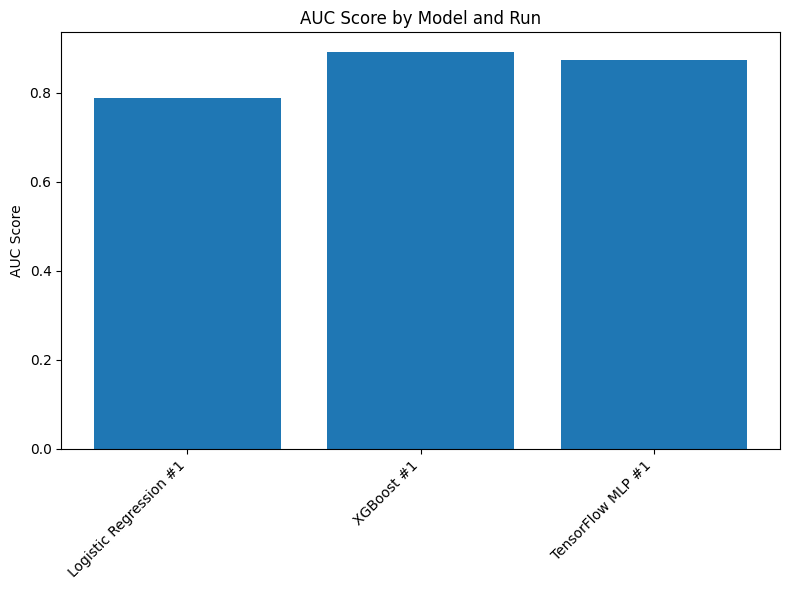

In [11]:
plot_metric(results, metric='auc')
# Other metrics are in the output above. The names don't exactly map, though, because I'm difficult. 
#"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

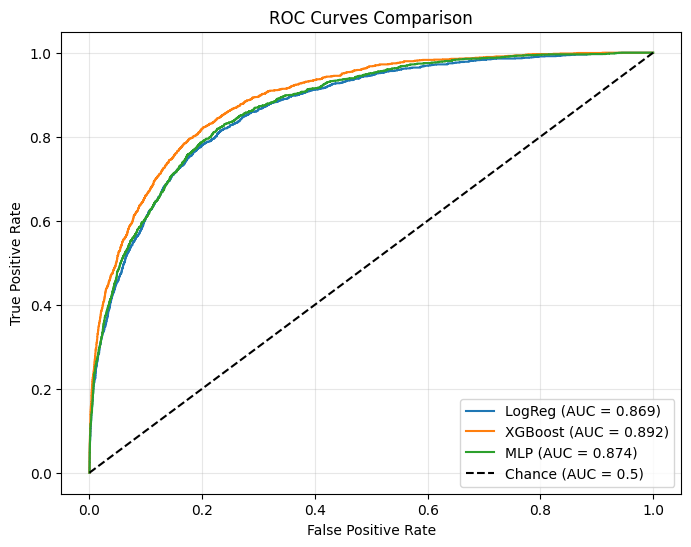

In [12]:
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)


/var/folders/jb/kvp9kzlj6nz00dgv9c8327yw0000gn/T/ipykernel_29562/3173379013.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]


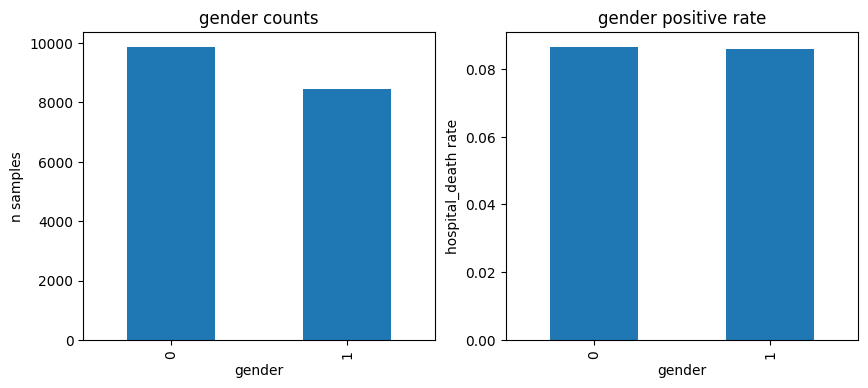

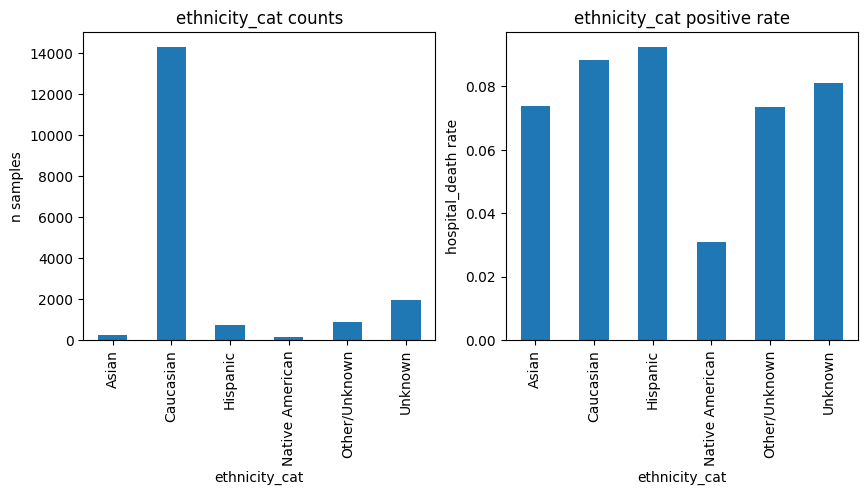

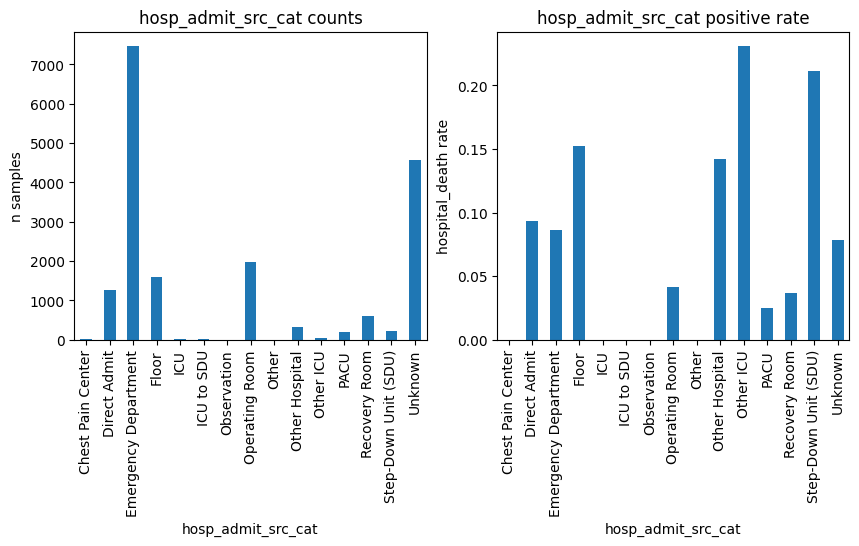

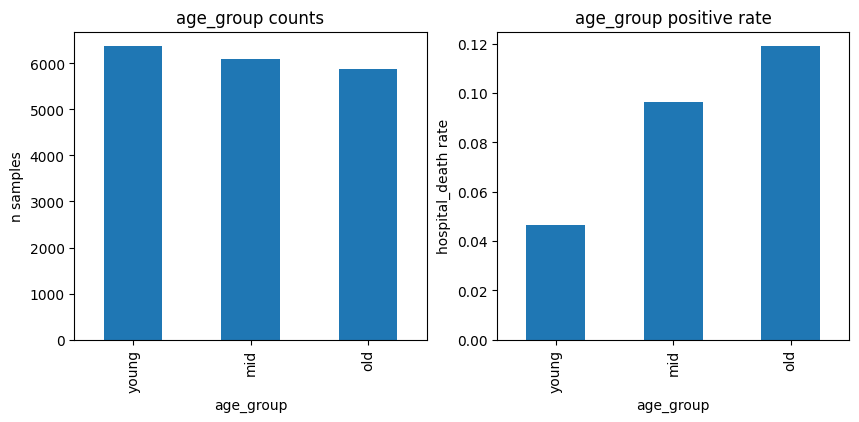

In [13]:
eth_cols = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

def decode_onehot(df, cols, prefix):
    def pick(row):
        ones = [c for c in cols if row[c] == 1]
        if len(ones) == 1:
            return ones[0].split(prefix,1)[1]
        else:
            return 'Unknown'
    return df.apply(pick, axis=1)

df_test = df_test.copy()
df_test['ethnicity_cat'] = decode_onehot(df_test, eth_cols, 'ethnicity_')

hosp_cols = [c for c in df_test.columns if c.startswith('hospital_admit_source_')]

df_test['hosp_admit_src_cat'] = decode_onehot(df_test, hosp_cols, 'hospital_admit_source_')

df_test['age_group'] = pd.qcut(df_test['age'], q=[0, 0.33, 0.66, 1.0], labels=['young','mid','old'])

demo_axes = {
    'gender' : df_test['gender'].unique(),
    'ethnicity_cat' : df_test['ethnicity_cat'].unique(),
    'hosp_admit_src_cat': df_test['hosp_admit_src_cat'].unique(),
    'age_group' : ['young','mid','old']}

models = [
    ('LogReg', y_pred_bal,  y_prob_lr),
    ('XGBoost', y_pred_xgb, y_prob_xgb),
    ('MLP', y_pred_mlp, y_prob_mlp),]


for axis in ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']:
    counts = df_test[axis].value_counts().sort_index()
    prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    counts.plot.bar(ax=ax1); ax1.set_title(f'{axis} counts'); ax1.set_xlabel(axis); ax1.set_ylabel('n samples')
    prevalence.plot.bar(ax=ax2); ax2.set_title(f'{axis} positive rate'); ax2.set_xlabel(axis); ax2.set_ylabel('hospital_death rate')

In [14]:
records = []
for model_name, y_pred, y_prob in models:
    for axis, groups in demo_axes.items():
        for grp in groups:
            mask = df_test[axis] == grp
            if mask.sum() < 30:
                continue
            yt = y_test[mask]
            yp = y_pred[mask]
            yp_prob = y_prob[mask]

            records.append({
                'model' : model_name,
                'demographic': axis,
                'group': grp,
                'n_samples': int(mask.sum()),
                'accuracy': accuracy_score(yt, yp),
                'auc': roc_auc_score(yt, yp_prob) if yt.nunique()>1 else float('nan'),
                'precision': precision_score(yt, yp, zero_division=0),
                'recall': recall_score(yt, yp, zero_division=0),
                'f1': f1_score(yt, yp, zero_division=0)})

df_subgroup = pd.DataFrame(records)

table = df_subgroup.pivot_table(index=['demographic','group'], columns='model', values=['accuracy','auc','f1'], aggfunc='first')

print(table)

                                         accuracy                      \
model                                      LogReg       MLP   XGBoost   
demographic        group                                                
age_group          mid                   0.804134  0.636483  0.794127   
                   old                   0.701277  0.502638  0.723234   
                   young                 0.889360  0.775110  0.894382   
ethnicity_cat      Asian                 0.795082  0.680328  0.782787   
                   Caucasian             0.800488  0.641172  0.806211   
                   Hispanic              0.742857  0.613605  0.771429   
                   Native American       0.820988  0.716049  0.827160   
                   Other/Unknown         0.818687  0.658509  0.844271   
                   Unknown               0.815509  0.638115  0.803345   
gender             0                     0.800728  0.650111  0.812968   
                   1                     0.800875  

574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


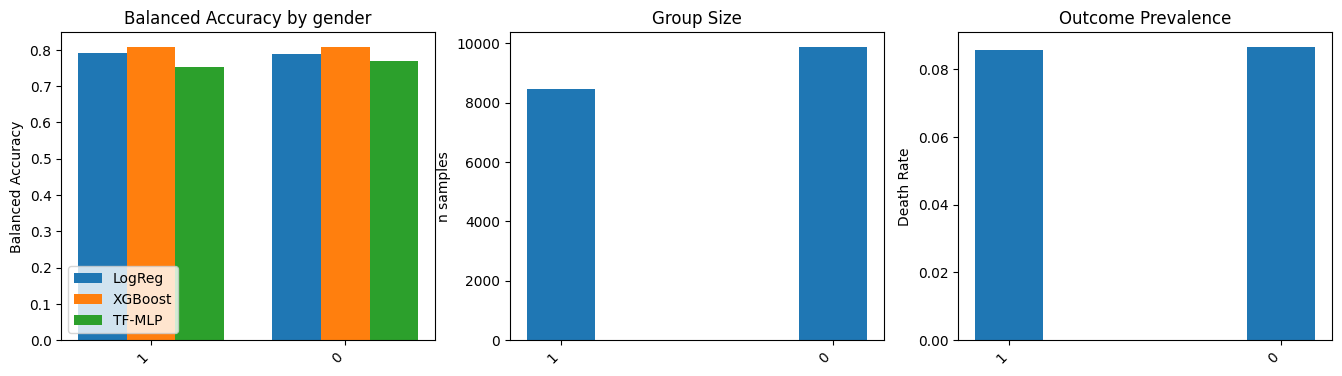

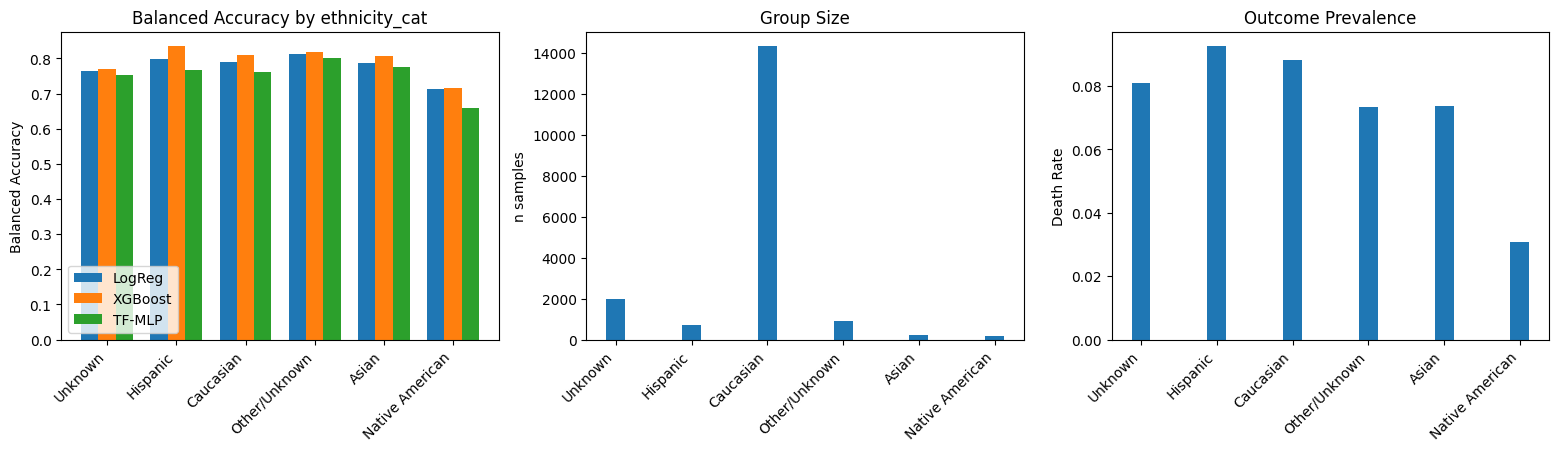

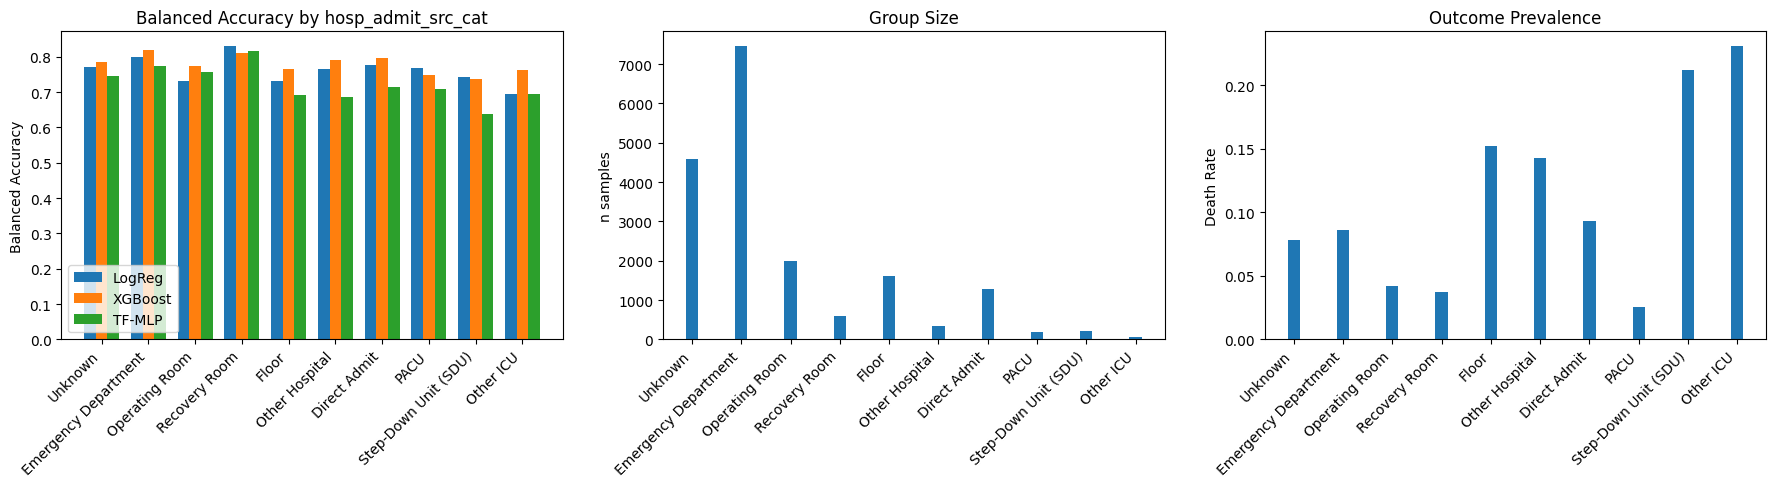

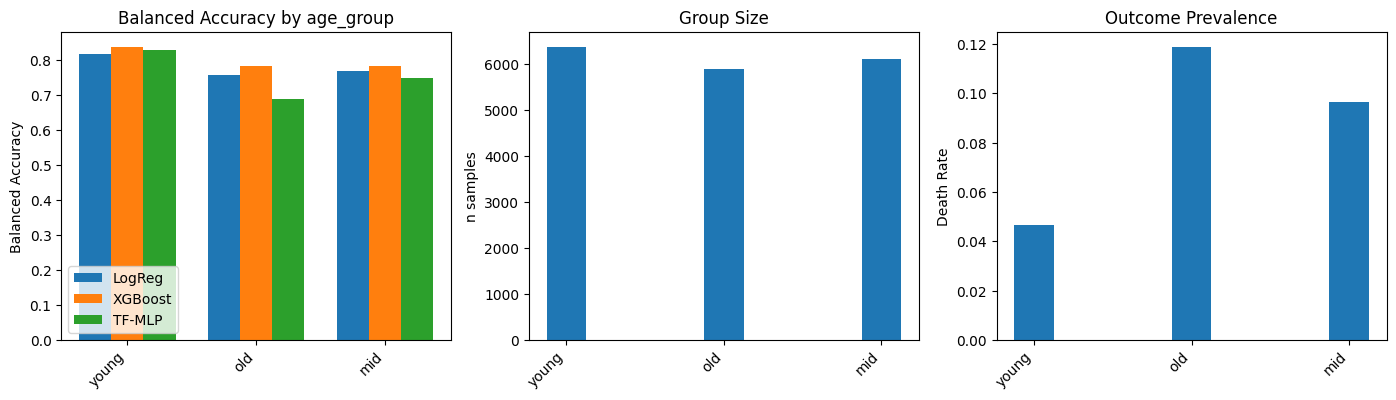

In [15]:
y_prob_lr  = log_clf_bal.predict_proba(X_test)[:,1]; y_pred_lr  = (y_prob_lr >= 0.5).astype(int)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]; y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
y_prob_mlp = mlp.predict(X_test).ravel();    y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)

demographics = ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']
models = [('LogReg',  y_pred_lr), ('XGBoost', y_pred_xgb), ('TF-MLP',  y_pred_mlp)]

records = []
for name, y_pred in models:
    for axis in demographics:
        for grp in df_test[axis].unique():
            mask = df_test[axis] == grp
            if mask.sum() < 30: 
                continue
            ba = balanced_accuracy_score(y_test[mask], y_pred[mask])
            records.append({'model': name, 'demographic': axis,'group': grp,
                'balanced_accuracy': ba, 'n_samples': mask.sum(), 'prevalence': df_test.loc[mask,'hospital_death'].mean()})
df_bal = pd.DataFrame(records)

for axis in demographics:
    df_axis = df_bal[df_bal['demographic']==axis]
    groups = list(df_axis['group'].unique())
    x = np.arange(len(groups))
    width = 0.25

    fig, (ax_ba, ax_count, ax_prev) = plt.subplots(1,3,figsize=(len(groups)*0.7+15,4))
    for i,(name,_) in enumerate(models):
        vals = []
        for grp in groups:
            sel = df_axis[(df_axis['model']==name)&(df_axis['group']==grp)]
            vals.append(sel['balanced_accuracy'].iloc[0] if not sel.empty else np.nan)
        ax_ba.bar(x + i*width, vals, width, label=name)
    ax_ba.set_xticks(x + width*(len(models)-1)/2)
    ax_ba.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_ba.set_title(f'Balanced Accuracy by {axis}')
    ax_ba.set_ylabel('Balanced Accuracy')
    ax_ba.legend(loc='lower left')

    counts = [ df_axis[df_axis['group']==grp]['n_samples'].iloc[0] for grp in groups ]
    ax_count.bar(x, counts, width)
    ax_count.set_xticks(x); ax_count.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_count.set_title('Group Size')
    ax_count.set_ylabel('n samples')

    prevs = [ df_axis[df_axis['group']==grp]['prevalence'].iloc[0] for grp in groups ]
    ax_prev.bar(x, prevs, width)
    ax_prev.set_xticks(x); ax_prev.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_prev.set_title('Outcome Prevalence')
    ax_prev.set_ylabel('Death Rate')

In [16]:
import pandas as pd
from sklearn.inspection import permutation_importance

# 1) Logistic Regression: top-10 by absolute coefficient
log_coefs = pd.Series(log_clf_bal.coef_.ravel(), index=X_train.columns)
top10_log = log_coefs.abs().sort_values(ascending=False).head(10)
print("=== Top 10 Logistic Regression Coefficients (abs) ===")
print(top10_log.to_string(), "\n")

# 2) XGBoost: top-10 by built-in importance
xgb_imp = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
top10_xgb = xgb_imp.sort_values(ascending=False).head(10)
print("=== Top 10 XGBoost Feature Importances ===")
print(top10_xgb.to_string(), "\n")

=== Top 10 Logistic Regression Coefficients (abs) ===
apache_2_diagnosis_123.0       1.819107
icu_admit_source_Other ICU     1.329518
apache_2_diagnosis_208.0       1.254416
apache_2_diagnosis_217.0       0.949920
apache_2_diagnosis_114.0       0.879612
ventilated_apache              0.847378
solid_tumor_with_metastasis    0.812705
apache_2_diagnosis_124.0       0.805920
apache_2_diagnosis_219.0       0.802351
gcs_unable_apache              0.791865 

=== Top 10 XGBoost Feature Importances ===
apache_4a_hospital_death_prob           0.094063
ventilated_apache                       0.019787
hospital_admit_source_Other Hospital    0.014018
icu_admit_source_Other ICU              0.012795
d1_spo2_min                             0.012627
d1_sysbp_min                            0.011325
apache_2_diagnosis_114.0                0.010777
gcs_motor_apache                        0.010368
solid_tumor_with_metastasis             0.010259
icu_type_CSICU                          0.010042 



In [17]:
y_prob_mlp = mlp.predict(X_test).ravel()
baseline_auc = roc_auc_score(y_test, y_prob_mlp)

importances = {}
for col in X_test.columns:
    X_perm = X_test.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)
    y_prob_perm = mlp.predict(X_perm).ravel()
    perm_auc = roc_auc_score(y_test, y_prob_perm)
    importances[col] = baseline_auc - perm_auc

imp = pd.Series(importances).sort_values(ascending=False)
print("Top 10 MLP features (manual permutation importance):")
print(imp.head(10).to_string())


574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
574/574 ━━━

## SHAP

### Linear Regression

In [56]:
# Initialize the explainer with the XGBoost model
explainer = shap.Explainer(log_clf_bal, X_train)
shap_values = explainer.shap_values(X_train)


/var/folders/jb/kvp9kzlj6nz00dgv9c8327yw0000gn/T/ipykernel_29562/202768453.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


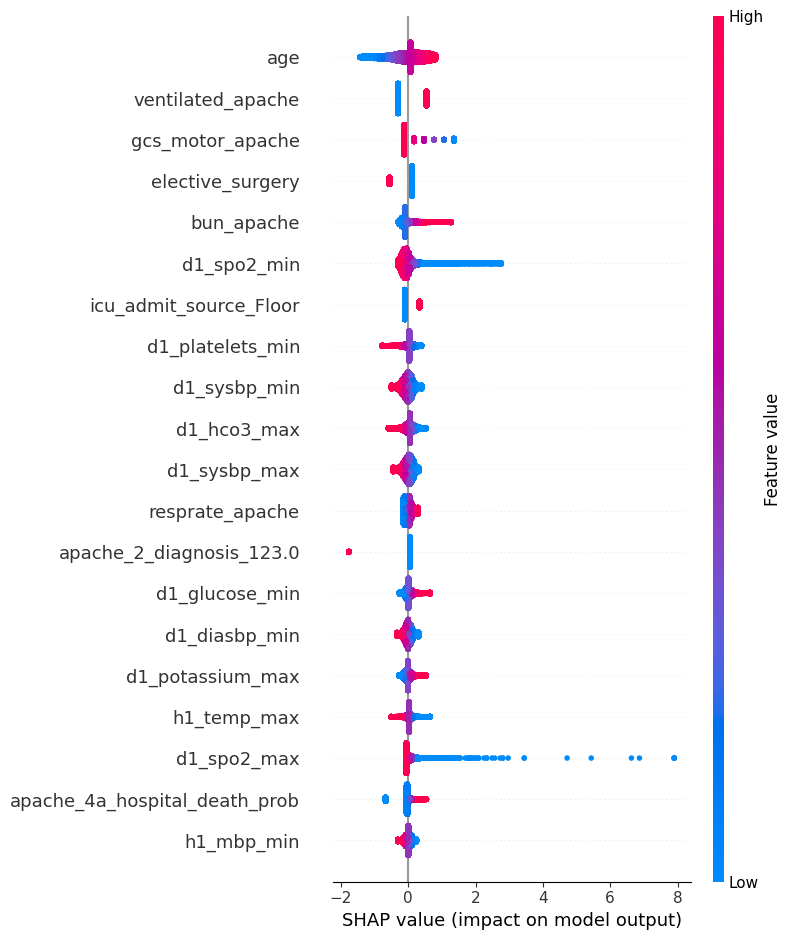

In [60]:
#type(shap_values), getattr(shap_values, "values", None)

# Extract values as float and rewrap in a new Explanation object
shap_values.values = shap_values.values.astype(np.float64)

# Now plot safely
shap.summary_plot(shap_values, X_train)

/var/folders/jb/kvp9kzlj6nz00dgv9c8327yw0000gn/T/ipykernel_29562/3432908747.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, plot_type='bar', feature_names = X_train.columns)


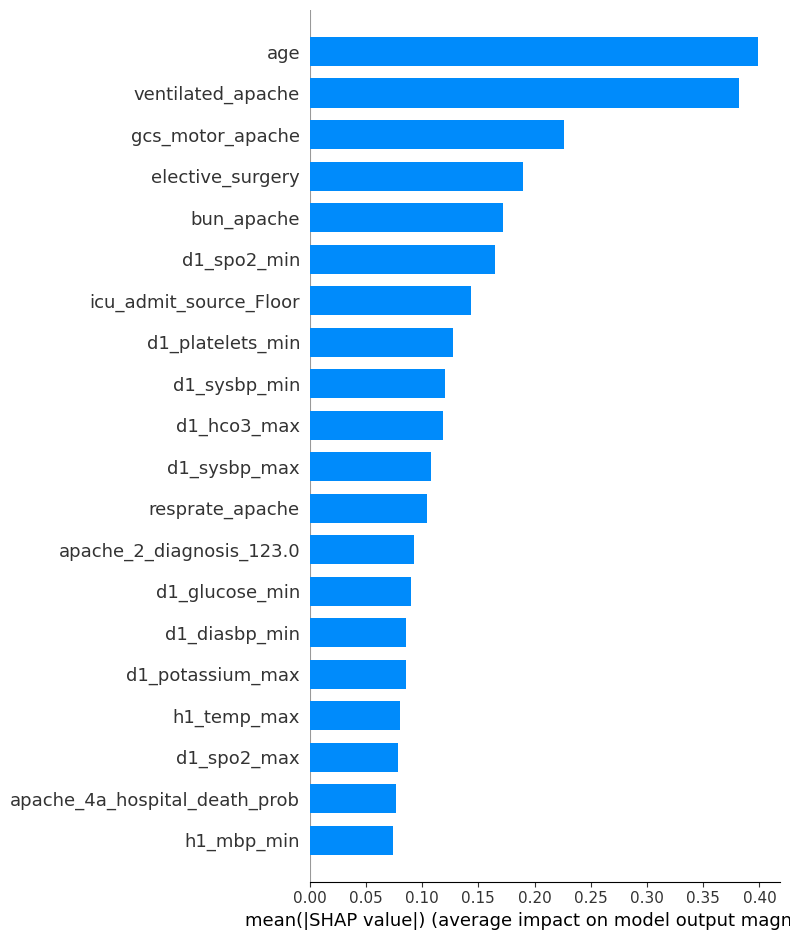

In [61]:
shap.summary_plot(shap_values, plot_type='bar', feature_names = X_train.columns)

In [62]:
explainer.expected_value

np.float64(-0.9494836900796559)


🔍 Dependence plot for: age


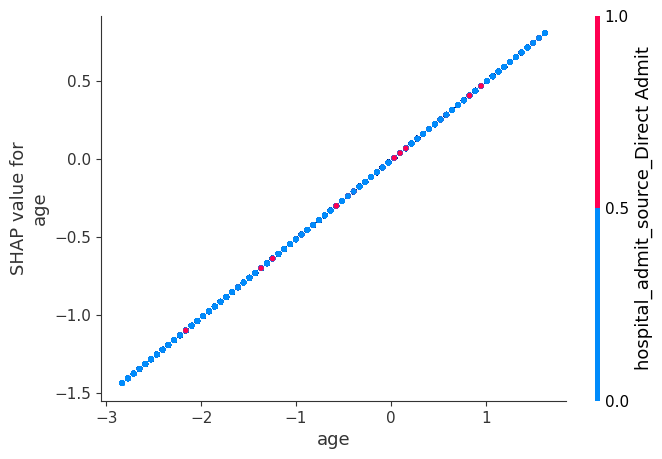


🔍 Dependence plot for: ventilated_apache


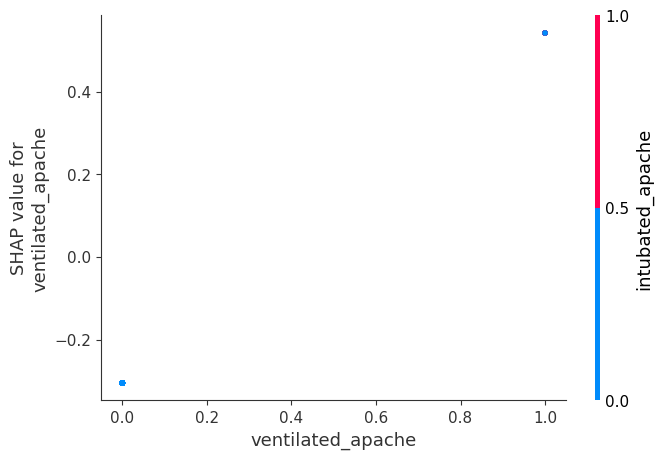


🔍 Dependence plot for: gcs_motor_apache


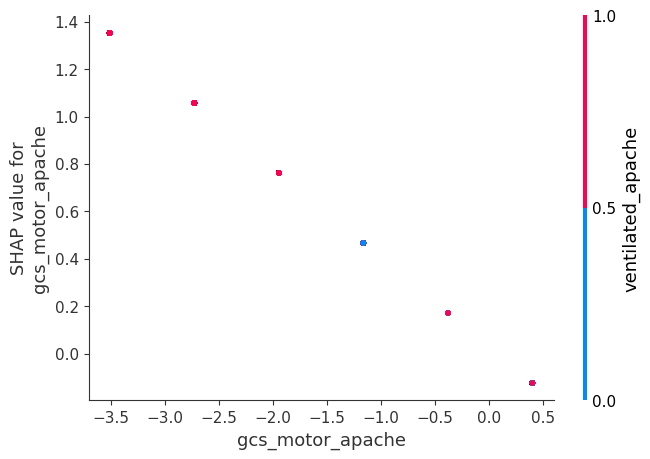


🔍 Dependence plot for: elective_surgery


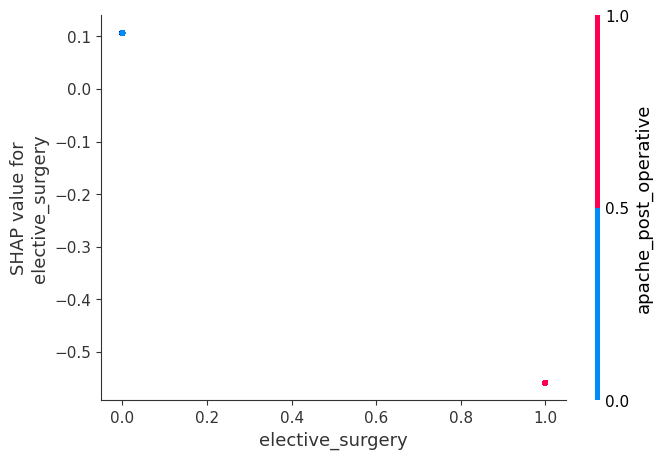


🔍 Dependence plot for: bun_apache


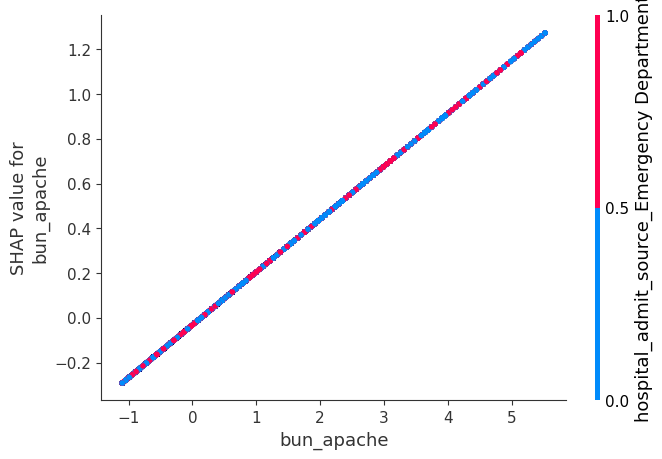

In [70]:
# 4. Dependence Plot (Feature vs. Impact)
raw_shap_values = shap_values.values.astype(np.float64)
mean_abs_shap = np.abs(raw_shap_values).mean(axis=0)

# Sort features by importance
top_idx = np.argsort(mean_abs_shap)[::-1]  # descending order
top_features = X_train.columns[top_idx[:5]] 

# Now this will work:
for feat in top_features:
    print(f"\n🔍 Dependence plot for: {feat}")
    shap.dependence_plot(feat, raw_shap_values, X_train)

In [68]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train) # for other models - not logistic regression???

AttributeError: 'LinearExplainer' object has no attribute 'shap_interaction_values'

### XGBoost

In [81]:
# Initialize the explainer with the XGBoost model
X_shap = X_train.astype(np.float64)
explainer2 = shap.Explainer(xgb_clf, X_shap)
shap_values2 = explainer2.shap_values(X_shap)

100%|===================| 73352/73370 [17:44<00:00]        

/var/folders/jb/kvp9kzlj6nz00dgv9c8327yw0000gn/T/ipykernel_29562/1999959566.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_shap)


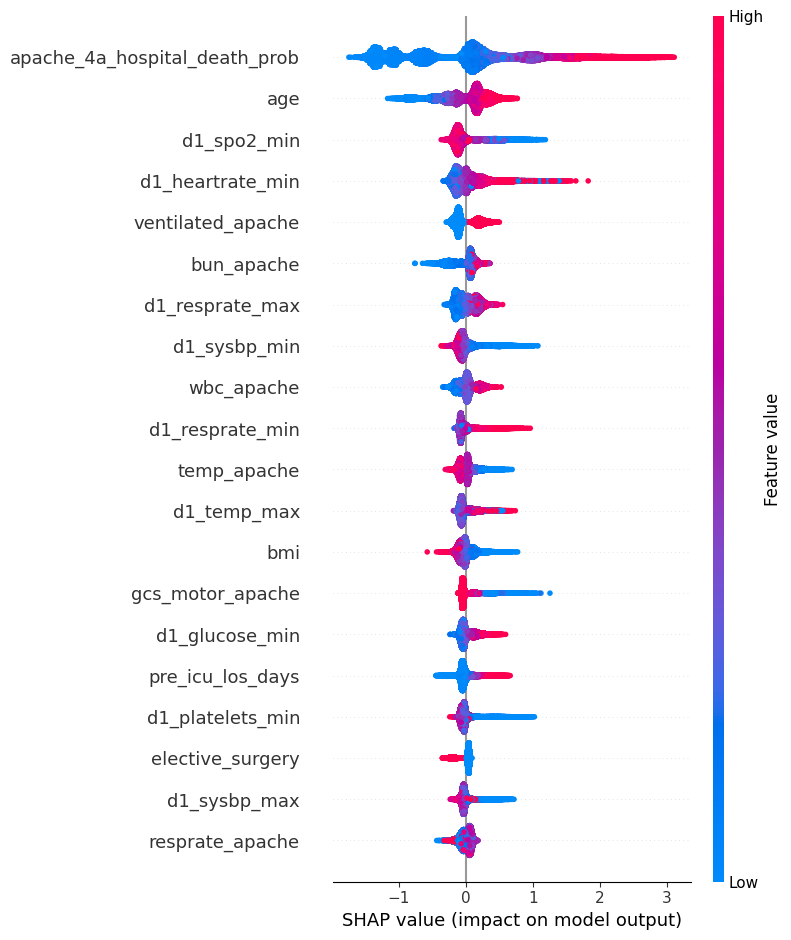

In [84]:
#type(shap_values), getattr(shap_values, "values", None)

# # Extract values as float and rewrap in a new Explanation object
# shap_values2.values = shap_values2.values.astype(np.float64)

# # Now plot safely
# shap.summary_plot(shap_values2, X_shap)

# shap_values2 = explainer2(X_shap)

shap.summary_plot(shap_values2, X_shap)

/var/folders/jb/kvp9kzlj6nz00dgv9c8327yw0000gn/T/ipykernel_29562/937898879.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, plot_type='bar', feature_names = X_shap.columns)


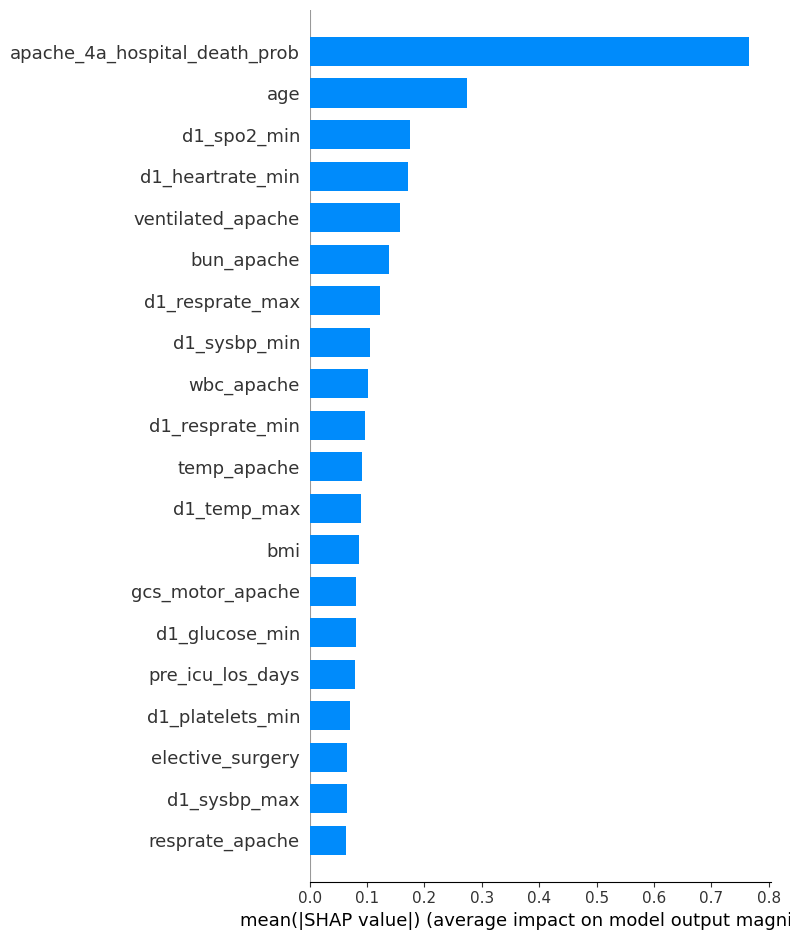

In [85]:
shap.summary_plot(shap_values2, plot_type='bar', feature_names = X_shap.columns)

In [86]:
explainer2.expected_value

np.float64(-1.3471120254427245)


🔍 Dependence plot for: apache_4a_hospital_death_prob


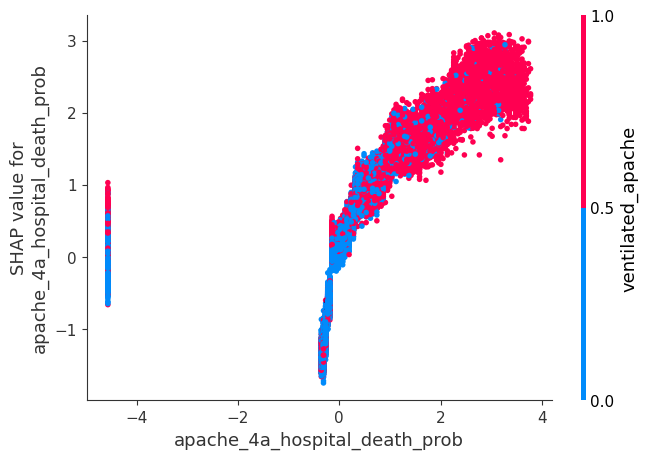


🔍 Dependence plot for: age


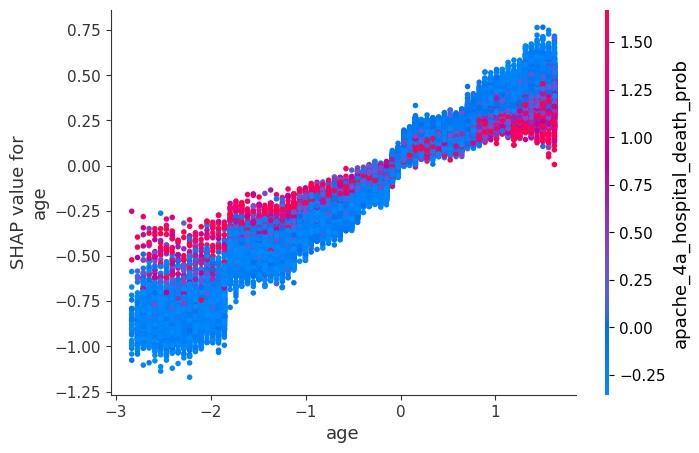


🔍 Dependence plot for: d1_spo2_min


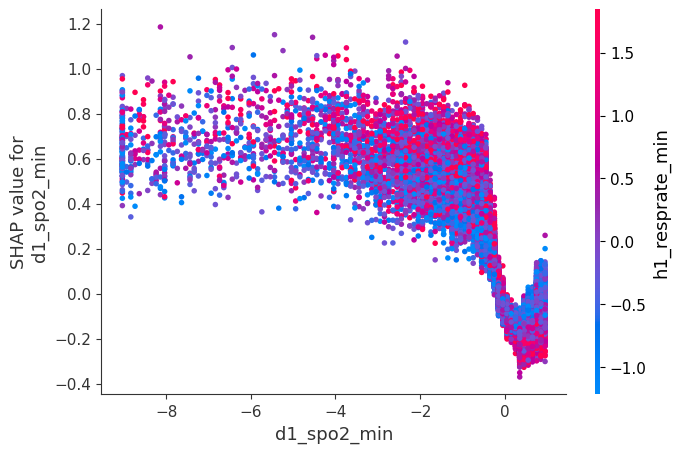


🔍 Dependence plot for: d1_heartrate_min


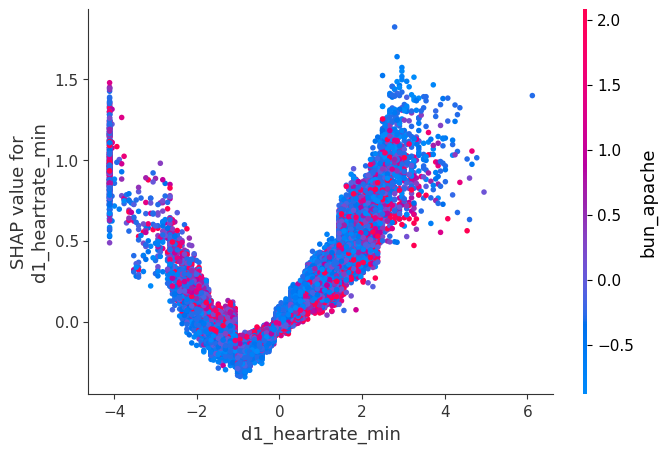


🔍 Dependence plot for: ventilated_apache


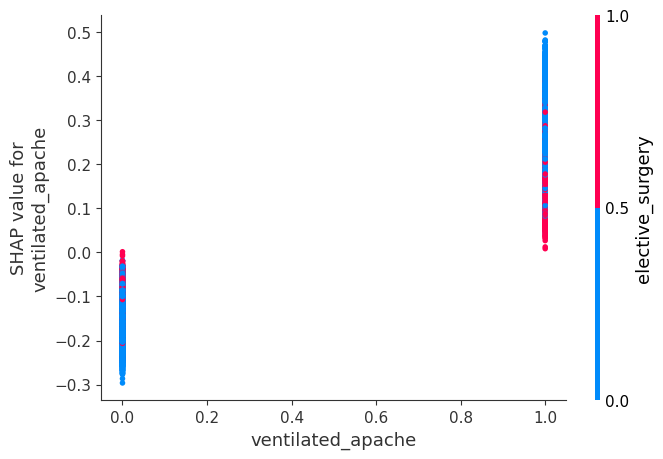

In [90]:
# 4. Dependence Plot (Feature vs. Impact)
# raw_shap_values2 = shap_values2.values.astype(np.float64)
mean_abs_shap2 = np.abs(shap_values2).mean(axis=0)

# Sort features by importance
top_idx2 = np.argsort(mean_abs_shap2)[::-1]  # descending order
top_features2 = X_train.columns[top_idx2[:5]] 

# Now this will work:
for feat in top_features2:
    print(f"\n🔍 Dependence plot for: {feat}")
    shap.dependence_plot(feat, shap_values2, X_shap)

### MLP

## LIME

### Linear Regression

In [78]:
explainer_l = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification'
)

# Explain a prediction (e.g., the 5th sample)
i = 5
exp = explainer_l.explain_instance(X_test.iloc[i], log_clf_bal.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

In [79]:
exp.save_to_file('lime_explanation.html')

### XGBoost

In [91]:
explainer_l2 = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification'
)

# Explain a prediction (e.g., the 5th sample)
i = 5
exp = explainer_l2.explain_instance(X_test.iloc[i], xgb_clf.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/alyssamiataliotou/Desktop/icu-dp/ienv/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

In [92]:
exp.save_to_file('lime_explanation2.html')